# Facial keypoints detection Kaggle Challenge

This is my attempt at using ML to complete the taks proposed by the challenge. 

The dataset consists of 96x96px images of faces, and the goal is to find the position of 15 features in each image. 

The train sets containts the pictures and the 30 (x,y) coordinates of the features for each training example. 

I'll begin by visualizing some of the pictures, and if possible their features. Then I'll think about how to detect the features. 

## Importing some useful libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

%matplotlib inline

##  Loading data

In [2]:
# Loading the training set

source_data = pd.read_csv('training.csv')

In [ ]:
source_data.info()

In [ ]:
type(source_data['Image'][0])

The pictures are given as strings. I will need to convert them to lists of integers. 

In [ ]:
# extracting all the pictures

photos = source_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

# Now I have the pictures as arrays of pixel intensity.

np.sqrt(len(photos[0])) # Checking that the arrays have the right size. 

In [ ]:
type(photos.head()[0])

In [ ]:
# Plotting a face.
plt.imshow(random.choice(photos).reshape(96,96),cmap='gist_gray')

Plotting some random faces to see what they look like.

In [ ]:
grid_size = 4
chosen_faces = random.sample(range(0,len(photos)), grid_size**2) #picking faces for a 4x4 grid. 

fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

for i, ax in zip(chosen_faces, axes.flat):

    ax.axis('off')
    ax.imshow(photos[i].reshape(96,96),cmap='gist_gray')
    
#plt.tight_layout()


## Gathering the features

Now that we have the faces, lets have a closer look at the features. 

In [ ]:
keypoints = source_data.drop('Image', axis = 1)

In [ ]:
keypoints.info()

In [ ]:
# Example 7041 is missing features. Lets plot it to see what that looks like.

#Getting the keypoints positions
guy_face = keypoints.iloc[7041]

x_points = [guy_face[i] for i in range(0,30,2)]
y_points = [guy_face[i+1] for i in range(0,30,2)] 

# Plotting a face.

plt.imshow(photos[7041].reshape(96,96),cmap='gist_gray')
plt.plot(x_points, y_points, 'ro', markerfacecolor = 'none')

In [ ]:
# Plotting faces with features

grid_size = 4
chosen_faces = random.sample(range(0,len(photos)), grid_size**2) #picking faces for a 4x4 grid. 

fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

for i, ax in zip(chosen_faces, axes.flat):

    ax.axis('off')
    ax.imshow(photos[i].reshape(96,96),cmap='gist_gray')
    
    x_points = [keypoints.iloc[i][j] for j in range(0,30,2)]
    y_points = [keypoints.iloc[i][j+1] for j in range(0,30,2)] 
    
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')


### Saving new dataframes with photos and keypoints to new csv files. 

In [ ]:
# This works, but you end up with a csv file of about 2gb. It is just not worth it nor necessary.
# My only reason for doing this was that I needed to use this on a different computer. 

"""photos_for_csv = source_data['Image'].apply(lambda str_pic: [int(px) for px in str_pic.split()])

photo_arr = np.array([l for l in photos_for_csv])

np.savetxt('training_photos.csv', photo_arr, delimiter = ',')"""

In [ ]:
"""photos.to_csv(r'training_photos.csv')
keypoints.to_csv(r'training_keypoints.csv')"""

#  Dealing with missing labels. 

I want to eventually put all of these train examples into a neural network, but first I need to deal with some issues. 

* MANY of the pictures are lacking some keypoints positions. This poses the problem of what the algorithm should find for those examples. I can think of a few alternatives:

    * Try to complete the missing labels and then use everything to train a NN that gives all 15 keypoints at once:
    
        * By manually finding and labelling the missing keypoints --> Of course not. 
        
        * Use the known labels as _features_, and train some sort of algorithm to find the rest of them. I could use KNN, for example, and fill in the missing info. I think it shouldn't take too long to give this a try. The problem is that I need to find batches of images having the same labels, to use as the Nearest Neighbors. So this would mean using vectors with different dimensions, or choosing at each step which features to ignore and to use as reference. __This sort of defeats the purpose: I would build a ML algorithm to find keypoints, and then use those keypoints to train a ML algorithm to find keypoints. The difference is that in the first case the feaures are known keypoints, while in the second they are the pixel intensities of the image, but still...__
        
        * Input the missing labels using the mean position of each feature, or by finding the distribution of positions for that feature and drawing randomly from it. 
    
    For all these methods of inputing the missing data I can sort of evaluate the result by looking at pictures with inputed keypoints, and see if the filled-in positions look more or less right. However, this does not sound very rigurous. 
    
    * If I don't want to fill in the missing labels, I could train one NN for each specific keypoints, and feed as trianing only images where the said keypoint is known. This implies training 15 different NNs, with a different number of training examples each. 
    
        * I could use these set of networks to predict the keypoints I need to give as a solution, or use them to complete the missing points, and then retrain. This souns more iterative and somewhat suboptimal. __Also quite redundant, and I'd probably be introducing some bias this way__.  

### Finding images with the same labeled keypoints. 

I want to make a table telling me which keypoints are already labelled for each training images. I guess veryfing that only one coordinate for the feature is enough. 

In [ ]:
# Making new columns names by removing the subindices. 
new_col_list = [keypoints.columns[i][:-2] for i in range(0,len(keypoints.columns),2)]
new_col_list

In [ ]:
# a dataframe saying which keypoints are marked on each image. 
present_keypoints = pd.DataFrame(columns = new_col_list)

In [ ]:
for col in new_col_list:
    present_keypoints[col] = pd.notnull(keypoints[col+'_x'])

In [ ]:
present_keypoints['Total'] = present_keypoints.sum(axis = 1)

In [ ]:
present_keypoints['Total'].value_counts()

In [ ]:
sns.heatmap(binary_df[binary_df['Total'] == 14].drop('Total', axis = 1), yticklabels=False,cbar=False,cmap='viridis')

So we see that most images have only four keypoints labelled, and that furthermore, for images with the same number of keypoints, the missings ones usually do no coincide. I could try and see which are the more and lees common missing points, but it is probably not very important. 

## Filling in missing keypoints

I'll try too see how does it look when I fill the missing labels with the mean.

In [ ]:
mean_positions = keypoints.mean()

In [ ]:
# Plotting faces with features

grid_size = 4
chosen_faces = random.sample(range(0,len(photos)), grid_size**2) #picking faces for a 4x4 grid. 

fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

for i, ax in zip(chosen_faces, axes.flat):

    ax.axis('off')
    ax.imshow(photos[i].reshape(96,96), cmap='gist_gray')
    
    x_points = [keypoints.iloc[i][j] for j in range(0,30,2)]
    y_points = [keypoints.iloc[i][j+1] for j in range(0,30,2)] 
    
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')
    
    filled_x = [keypoints.mean()[j] if np.isnan(x_points[int(j/2)]) else np.nan for j in range(0,30,2) ]
    filled_y = [keypoints.mean()[j+1] if np.isnan(y_points[int(j/2)]) else np.nan for j in range(0,30,2) ]
    
    ax.plot(filled_x, filled_y, 'bD', markerfacecolor = 'none')

In [ ]:
# Creating a df with complementary keypoints.

complement_keypoints = pd.DataFrame(columns = keypoints.columns)

In [ ]:
keypoints[pd.notnull(keypoints)].iloc[7041] 

In [ ]:
(4 - np.nan ) * 0

In [ ]:
for i in range(len(keypoints[pd.notnull(keypoints)].iloc[7041] )):
    if np.isnan(keypoints[pd.notnull(keypoints)].iloc[7041][i] ):
        print('replace')
    else:
        print('ignore')

##  Missing labels and Tensorflow

My goal is to train a CNN to identify the keypoints. I need to check wheter the loss function included in tensorflow can handle the missing labels. 

I will create some random predictions, including some Nan values on the real labels, and see what tensorflow does. I think I will need to include some weights to remove the coordinates for which I have no predictions. 

In [ ]:
import tensorflow as tf

In [ ]:
y_preds = np.arange(5) + (2*np.random.rand(5) - 1) # Randome values for my predictions.
y_true = np.arange(5) * 1.0 # true values

In [ ]:
plt.plot(np.arange(5))
plt.plot(np.arange(5), y_preds, 'r*')

In [ ]:
# Now let's put some nan values
y_true[[2,4] ]= np.nan

y_true

In [ ]:
plt.plot(np.arange(5))
plt.plot(np.arange(5), y_true, 'bo')
plt.plot(np.arange(5), y_preds, 'r*')

In [ ]:
# PLACEHOLDERS for the loss function
preds = tf.placeholder(tf.float32, [None, 1])
full_true = tf.placeholder(tf.float32, [None, 1])
true = tf.placeholder(tf.float32, [None, 1])

weights = tf.placeholder(tf.float32, [None, 1])

In [ ]:
# And now let's creat a tensorflow thing that computes the mean squared error.
# I could use the argument weigths to ignore the terms that dont have labels, provided it multiplies by zero. 

full_error = tf.losses.mean_squared_error(preds, full_true)
nan_error = tf.losses.mean_squared_error(preds, true)
nan_error_weights = tf.losses.mean_squared_error(preds, true, weights )

# I found the solution! I need a boolean mask!

boolean_error = tf.reduce_mean(tf.square(tf.boolean_mask(preds - true, tf.is_finite(true))))
mean_err_mask = tf.losses.mean_squared_error(tf.boolean_mask(preds, tf.is_finite(true)), 
                                             tf.boolean_mask(true, tf.is_finite(true)) 
                                            )

In [ ]:
# setting the values

y_preds = (np.arange(5) + (2*np.random.rand(5) - 1)).reshape((-1,1)) # Randome values for my predictions.
full_y_true = (np.arange(5) * 1.0).reshape((-1,1))

y_true = np.arange(5) * 1.0 # true values
y_true[[2,4] ]= np.nan
y_true = y_true.reshape((-1,1))

weight_vals = np.isfinite(y_true) *1

In [ ]:
with tf.Session() as sess:
    test = sess.run(tf.square(tf.boolean_mask(preds - true, tf.is_finite(preds-true))), 
             feed_dict={preds:y_preds, true:y_true})

In [ ]:
test

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    
    sess.run(init)
    
    full = sess.run(full_error, feed_dict = {preds:y_preds, full_true:full_y_true } )
    nan_e = sess.run(nan_error, feed_dict = {preds:y_preds, true:y_true } )
    nan_e_weights = sess.run(nan_error, feed_dict = {preds:y_preds, true:y_true, weights:weight_vals } )
    bool_err = sess.run(boolean_error, feed_dict = {preds:y_preds, true:y_true } )
    full_bool_err = sess.run(boolean_error, feed_dict = {preds:y_preds, true:full_y_true } )
    
    

In [ ]:
print(nan_e, nan_e_weights, full, full_bool_err, bool_err)

In [ ]:
import time

In [ ]:
# Let's see which way is faster

start_time = time.time()

with tf.Session() as sess:
    
    sess.run(init)
    
    bool_err = sess.run(boolean_error, feed_dict = {preds:y_preds, true:y_true } )
    
duration = time.time() - start_time
print('Time using custom function ', duration)
print('Custom error: ', bool_err)

In [ ]:
start_time = time.time()

with tf.Session() as sess:
    
    sess.run(init)
    
    bool_err = sess.run(mean_err_mask, feed_dict = {preds:y_preds, true:y_true } )
    
duration = time.time() - start_time
print('Time using built in mse', duration)
print('Built in mse: ', bool_err)

So the custom function is faster! It makes sense, because I am only applying the mask once. 

I think I have everything I need to try to implement the model. Maybe it is more practical to do this in a different notebook.

# Doubling the training set

In [3]:
source_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [5]:
images = source_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

images = np.vstack([images.iloc[i] for i in range(len(images))])

In [95]:
test_images = images[0,:]

In [96]:
test_images.shape

(9216,)

In [117]:
flipped_im = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_im[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [118]:
flipped_im.shape

(7049, 9216)

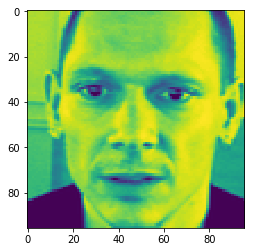

In [120]:
plt.imshow(flipped_im[37].reshape(96,96))

In [122]:
full_images = np.vstack((images, flipped_im))

In [123]:
full_images.shape

(14098, 9216)

In [128]:
all_keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

In [129]:
all_keypoints.iloc[7045:7060]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,47.910346,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,49.462572,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,50.754202,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447
7048,66.938311,43.424510,31.096059,39.528604,NaN,NaN,NaN,NaN,NaN,NaN,...,47.069250,73.033339,NaN,NaN,NaN,NaN,NaN,NaN,45.900480,82.773096
7049,64.772992,36.421678,28.966436,39.002274,58.643429,37.389402,71.547128,37.389402,35.417925,39.647423,...,50.579429,57.066803,66.385504,77.388992,33.804692,79.970165,51.687398,72.935459,51.869293,84.485774
7050,65.050723,33.448715,30.667064,34.970077,58.965277,34.361532,70.527489,33.144443,36.143830,35.274349,...,46.793702,55.660936,59.877617,76.047660,38.578553,76.352000,48.315404,70.266553,49.532085,85.480170
7051,64.096211,34.909642,29.942947,34.909642,57.321895,36.320968,70.023579,36.603221,35.588000,36.320968,...,47.442737,53.538947,61.273684,72.732000,34.177053,73.014316,47.725053,70.191789,47.725053,78.659368
7052,62.976904,37.261774,29.774261,37.261774,57.381357,38.754115,69.692730,38.007903,34.996661,39.127179,...,43.114922,54.166539,57.754504,74.195478,29.401113,72.703722,44.696835,70.091687,43.438817,78.268383
7053,62.755190,38.042032,28.274699,39.621261,58.017620,39.094852,72.493890,38.305237,36.434110,39.621261,...,51.700466,64.889521,63.808245,76.997301,34.328589,77.523239,50.037252,73.707387,50.772859,86.871166
7054,65.816449,37.563364,25.319252,39.968748,58.598953,39.367626,73.234467,38.565533,32.135701,40.169271,...,42.531514,58.800000,63.009570,81.669084,30.130916,82.471178,45.691888,78.487626,45.567626,93.898766


In [6]:
keypoints = source_data.drop('Image', axis = 1)

In [7]:
test_im = images[0]
test_keypoints = keypoints.iloc[0]

In [14]:
pic = test_im.reshape(96,96)


In [75]:
reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# It may be easier to make a for loop by looking at the strings. 
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    #reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    #the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

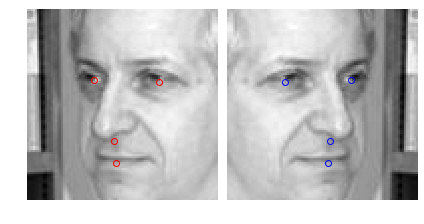

In [90]:
n = 7033 #chose image index
fig, axes = plt.subplots(1, 2, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(7,7))

axes[0].axis('off')
axes[1].axis('off')

axes[0].imshow(images[n].reshape(96,96),cmap='gist_gray')
x_points = [keypoints.iloc[n][j] for j in range(0,30,2)]
y_points = [keypoints.iloc[n][j+1] for j in range(0,30,2)] 

axes[0].plot(x_points, y_points, 'ro', markerfacecolor = 'none')

axes[1].imshow(np.flip(images[n].reshape(96,96),1),cmap='gist_gray')

R_x_points = [reflected_keypoints.iloc[n][j] for j in range(0,30,2)]
R_y_points = [reflected_keypoints.iloc[n][j+1] for j in range(0,30,2)] 


axes[1].plot(R_x_points, R_y_points, 'bo', markerfacecolor = 'none')

